# Setup

In [2]:
import json
import yaml
import matplotlib.pyplot as plt
import networkx as nx
import imageio
import torch

from dataset_road_network import build_road_network_data
from utils import image_graph_collate_road_network

from monai.data import DataLoader
from torchvision.transforms import Compose, Normalize
from matplotlib.pyplot import figure

%load_ext autoreload
%autoreload 2

In [3]:
class obj:
    def __init__(self, dict1):
        self.__dict__.update(dict1)

def dict2obj(dict1):
    return json.loads(json.dumps(dict1), object_hook=obj)

config_path = 'configs/road_rgb_2D.yaml'
# Load the config files
with open(config_path) as f:
    print('\n*** Config file')
    print(config_path)
    config = yaml.load(f, Loader=yaml.FullLoader)
    print(config['log']['message'])
config = dict2obj(config)

inv_norm = Compose([ 
    Normalize(
        mean = [ 0., 0., 0. ],
        std = [ 1/0.229, 1/0.224, 1/0.225 ]
    ),
    Normalize(
        mean = [ -0.485, -0.456, -0.406 ],
        std = [ 1., 1., 1. ]
    ),
])

def ensure_format(bboxes):
    boxes_new = []
    for bbox in bboxes:
        if bbox[0] > bbox[2]:
            bbox[0], bbox[2] = bbox[2], bbox[0]
        if bbox[1] > bbox[3]:
            bbox[1], bbox[3] = bbox[3], bbox[1]

        # to take care of horizontal and vertical edges
        if bbox[2]-bbox[0]<0.2:
            bbox[0] = bbox[0]-0.075
            bbox[2] = bbox[2]+0.075
        if bbox[3]-bbox[1]<0.2:
            bbox[1] = bbox[1]-0.075
            bbox[3] = bbox[3]+0.075

        boxes_new.append(bbox)
    return np.array(boxes_new)

def draw_graph(nodes, edges, ax):
    # Create Graph for plotting graphs for actual data and prediction
    cur_graph = nx.Graph()

    # Add all nodes
    for ind, pos in enumerate(nodes):
        # The positions have to be altered so that the graph has the right orientation (all coordinates are normalized to [0,1])
        cur_graph.add_node(ind, pos=(pos[1].item(), 1 - pos[0].item()))

    # Add positions to nodes
    pos = nx.get_node_attributes(cur_graph,'pos')

    # Add all edges
    for edge in edges:
        cur_graph.add_edge(edge[0].item(), edge[1].item())

    # Draw Graphs with matplotlib
    nx.draw_networkx(cur_graph, pos, ax, node_size=20, with_labels=False)
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True, grid_color='r')
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)


*** Config file
configs/road_rgb_2D.yaml
pretrained_munich_lr0_lr-encoder0_lr-backbone1e-5_train-cnn-true_decay1e-4


# Visualization of big picture of 20 US Cities Dataset

This is every 10th picture of the 20 US Cities Dataset

In [14]:
set_name = "global_diverse_cities"
city_name_list = 'configs/cities.json'

step_size = 1
min_index = 0
max_index = 9

# Load city names from file
cities = []
dataset_cfg_ = json.load(open(city_name_list, "r"))
for item in dataset_cfg_:
    cities.append({"name": item["cityname"], "id": item["id"]})

root_dir = f"/media/data/alex_johannes/data/{set_name}"

rows = ((max_index - min_index) // step_size) // 3 + 1

fig, axs = plt.subplots(rows, 3)
fig.set_size_inches(20,rows * 6)
image_no = 0

for ind in range(min_index, max_index, step_size):
    try:
        sat_img = imageio.imread(root_dir + "/%s_region_%d_sat.png" % (city_names[ind], ind))
    except:
        sat_img = imageio.imread(root_dir + "/%s_region_%d_sat.jpg" % (city_names[ind], ind))

    # Add image to subplot
    axs[image_no // 3, image_no % 3].imshow(sat_img)

    # Turn off labels for axis for all graphs
    axs[image_no // 3, image_no % 3].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    # Turn off labels for axis for all graphs
    axs[image_no // 3, image_no % 3].annotate(ind, (0,0))


    image_no += 1

KeyError: 'id'

# Visualization of actual training data
This is a visualization of the data that will be used for training (incl. Segmentation and Target graph) of 100 samples from the 20 US Cities dataset

In [ ]:
# Loading the data
ds = build_road_network_data(
    config, mode='test'
)

loader = DataLoader(
    ds,
    batch_size=config.DATA.BATCH_SIZE,
    shuffle=True,
    num_workers=config.DATA.NUM_WORKERS,
    collate_fn=image_graph_collate_road_network,
    pin_memory=True
)

num_samples = 50
start_index = 0

# Create figure with 3 plots
fig, axs = plt.subplots(num_samples, 3)
fig.set_size_inches(20,6 * num_samples)

for i in range(start_index, start_index + num_samples):

    # Selecting a sample
    sample = ds[i]

    # Preparing the sample (especially reversing the normalization)
    image, seg, nodes, edges = sample[0], sample[1], sample[2], sample[3]
    image = inv_norm(image)
    seg = torch.reshape(seg, (128,128))

    # Draw images
    axs[i, 0].imshow( image.permute(1,2,0) )
    axs[i, 1].imshow( seg, cmap='gray' )

    axs[i, 0].annotate(i, xy=(0,0))

    
    # Create Graph for plotting graph
    G = nx.Graph()

    # Add all nodes 
    for ind, pos in enumerate(nodes):
        # The positions have to be altered so that the graph has the right orientation (all cooridnates are normalized to [0,1])
        #print(f"node: {ind}, position: {(pos[1].item(), 1 - pos[0].item())}")
        G.add_node(ind, pos=(pos[1].item(), 1 - pos[0].item()))

    #print(edges)

    # Add positions to nodes
    pos = nx.get_node_attributes(G,'pos')

    # Add all edges
    for edge in edges:
        G.add_edge(edge[0].item(), edge[1].item())

    # Draw Graph with matplotlib
    nx.draw(G, pos, axs[i, 2], node_size=20, with_labels=False)

    axs[i,2].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    axs[i,2].set_xlim(0,1)
    axs[i,2].set_ylim(0,1)


    # Style the graph
    limits = plt.axis('on')

    # Turn off labels for axis for all graphs
    for x in axs[i]:
        x.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

# Show graph
plt.show()

PolyData (0x7f38adb2d060)
  N Cells:	12
  N Points:	8
  X Bounds:	3.906e-02, 5.784e-01
  Y Bounds:	3.906e-02, 3.454e-01
  Z Bounds:	0.000e+00, 0.000e+00
  N Arrays:	0



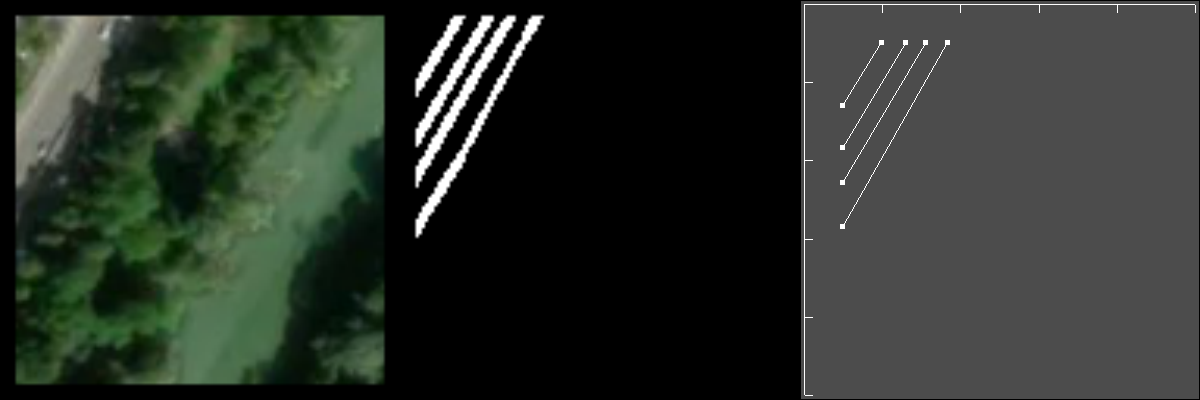

In [7]:
import os
import pyvista

image_id = '000584'
path = "/media/data/alex_johannes/data/global_diverse_cities/munich/test_data"

plotter = pyvista.Plotter(shape=(1,3))

vtk_folder = os.path.join(path, 'vtp')
img_folder = os.path.join(path, 'raw')
seg_folder = os.path.join(path, 'seg')

# Showing sat image
plotter.subplot(0,0)
img_file = os.path.join(img_folder, f'sample_{image_id}_data.png')
plotter.add_background_image(img_file, as_global=False)

# Showing seg image
plotter.subplot(0,1)
seg_file = os.path.join(seg_folder, f'sample_{image_id}_seg.png')
plotter.add_background_image(seg_file, as_global=False)

# Plotting graph
plotter.subplot(0,2)
vtk_file = os.path.join(vtk_folder, f'sample_{image_id}_graph.vtp')
vtk_data = pyvista.read(vtk_file)
print(vtk_data)
_ = plotter.add_mesh(vtk_data)
plotter.show_bounds(show_zaxis=False, bounds=[0,1,0,1,0,1])

# Fix orientation for graph
plotter.camera_position = 'xy'
plotter.camera.roll -= 90
plotter.camera.zoom(3.5)


# Show everything
plotter.window_size = [1200, 400]
plotter.show(jupyter_backend="static")


# Testing the model

## Importing things

In [4]:
import torch
from monai.data import DataLoader
from tqdm import tqdm
import numpy as np

from dataset_road_network import build_road_network_data
from models import build_model
from inference import relation_infer
from metric_smd import StreetMoverDistance
from metric_map import BBoxEvaluator
from box_ops_2D import box_cxcywh_to_xyxy_np
from utils import image_graph_collate_road_network
from metrics.topo import compute_topo
from models.matcher import build_matcher
from losses import SetCriterion

config_path = 'configs/road_rgb_2D.yaml'
# Load the config files
with open(config_path) as f:
    print('\n*** Config file')
    print(config_path)
    config = yaml.load(f, Loader=yaml.FullLoader)
    print(config['log']['message'])
config = dict2obj(config)

print(f"batch size: {config.DATA.TEST_BATCH_SIZE}")
print(f"tes file: {config.DATA.TEST_DATA_PATH}")


*** Config file
configs/road_rgb_2D.yaml
pretrained_munich_lr0_lr-encoder0_lr-backbone1e-5_train-cnn-true_decay1e-4
batch size: 16
tes file: /media/data/alex_johannes/data/global_diverse_cities/munich/test_data/


## Setting up Model & Dataloader

In [13]:
checkpoint = '/home/alex_johannes/relationformer/trained_weights/runs/pretrained_munich_lr2e-4_lr-encoder2e-4_lr-backbone2e-5_train-cnn-true_decay1e-4_10/models/checkpoint_epoch=97.pt'
#checkpoint = './trained_weights/supro/20_US_cities_checkpoint_epoch=80.pt'
max_rows = 15

# Loading the data
ds = build_road_network_data(
    config, mode='test'
)

loader = DataLoader(
    ds,
    batch_size=config.DATA.TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=config.DATA.NUM_WORKERS,
    collate_fn=image_graph_collate_road_network,
    pin_memory=True
)

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True
torch.multiprocessing.set_sharing_strategy('file_system')
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

net = build_model(config).to(device)

# load checkpoint
checkpoint = torch.load(checkpoint, map_location='cpu')
net.load_state_dict(checkpoint['net'])
net.eval()

"""
Setting up metrics for quantitative evaluation
"""
# init metric
metric_smd = StreetMoverDistance(eps=1e-5, max_iter=10, reduction='none')
smd_results = []
topo_results = []
loss_results = []

metric_node_map = BBoxEvaluator(['node'], max_detections=100)
metric_edge_map = BBoxEvaluator(['edge'], max_detections=100)

"""
Setting up loss function
"""
matcher = build_matcher(config)
loss_function = SetCriterion(config, matcher, net)

## Creating and plotting results

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00,  1.22s/it]


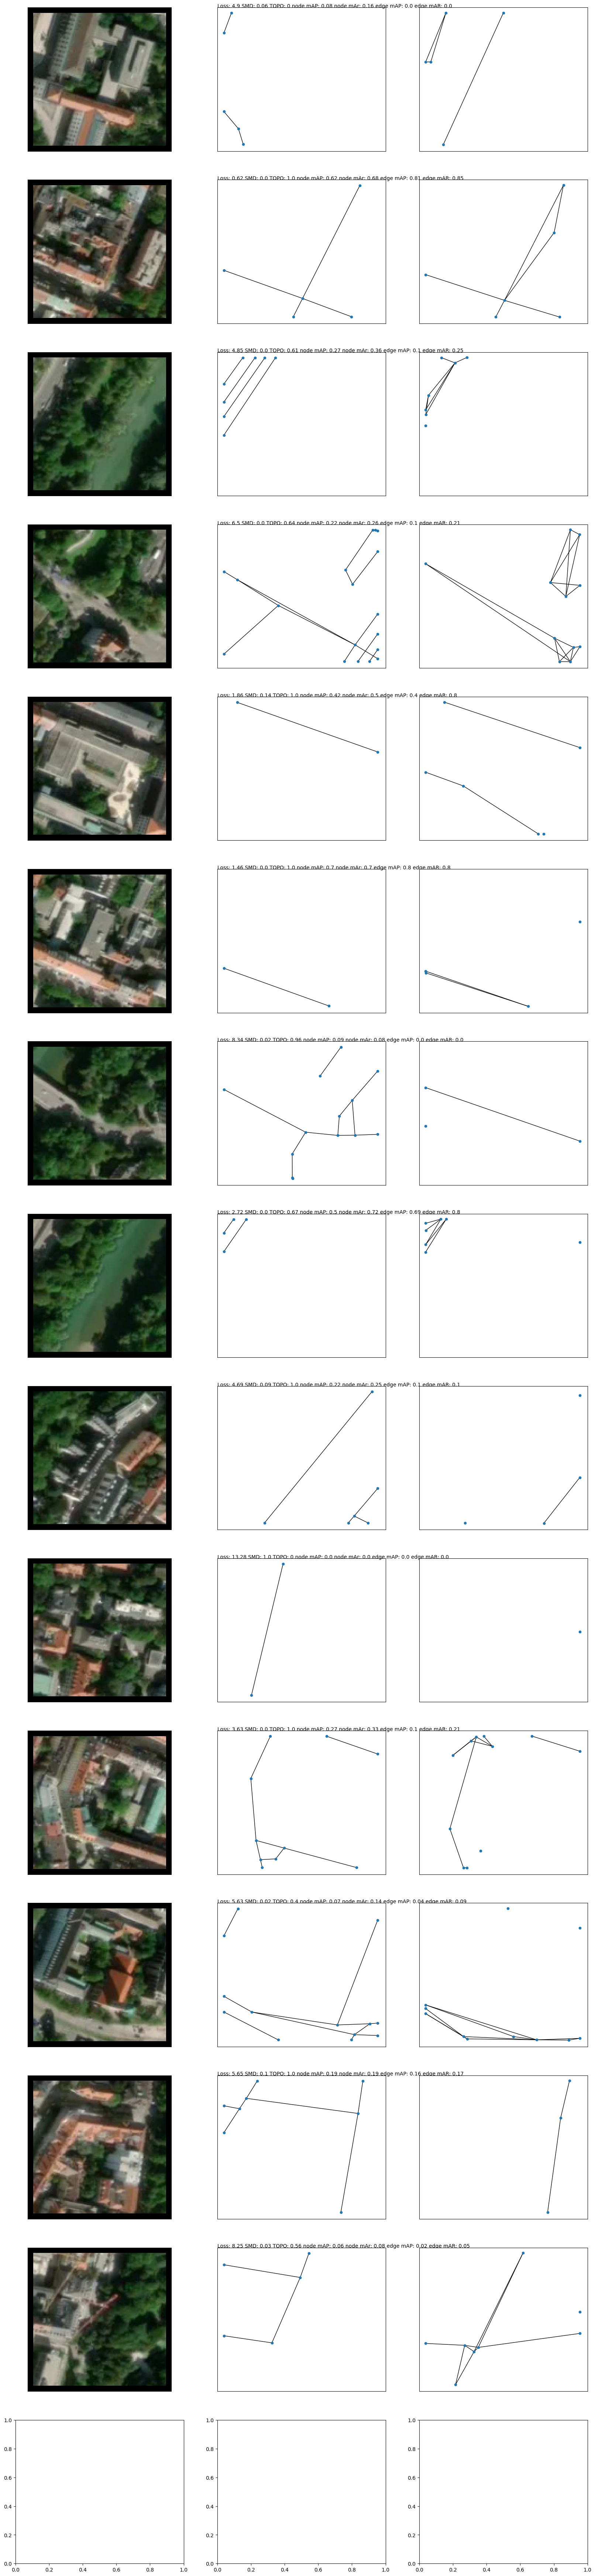

mean losses: 5.602871417999268
topo mean: [0.66071576 0.63180539]
smd value: mean 0.11730705201625824, std 0.2479635328054428

node mAP_IoU_0.50_0.95_0.05_MaxDet_100 0.1655383098464791
node mAR_IoU_0.50_0.95_0.05_MaxDet_100 0.28902438618242743
edge mAP_IoU_0.50_0.95_0.05_MaxDet_100 0.08317712181349202
edge mAR_IoU_0.50_0.95_0.05_MaxDet_100 0.18630514703691006


In [14]:
# Create figure with 3 plots per row
fig, axs = plt.subplots(max_rows, 3)
fig.set_size_inches(20,6 * max_rows)

row_counter = 0

with torch.no_grad():
    for batchdata in tqdm(loader):
        # extract data and put to device
        images, segs, nodes, edges = batchdata[0], batchdata[1], batchdata[2], batchdata[3]

        # Specific for munich dataset - bad samples are characterized by too many nodes
        if nodes[0].shape[0] > 80:
            print(f"continue row: {row_counter}")
            continue

        images = images.to(device,  non_blocking=False)
        segs = segs.to(device,  non_blocking=False)
        nodes = [node.to(device,  non_blocking=False) for node in nodes]
        edges = [edge.to(device,  non_blocking=False) for edge in edges]
        nodes1 = [node.to(device,  non_blocking=False) for node in nodes]
        edges1 = [edge.to(device,  non_blocking=False) for edge in edges]

        h, out, _ = net(images, seg=False)

        target = {'nodes': nodes, 'edges': edges}

        losses = loss_function(
            h,
            out,
            target
        )
        loss_results.append(losses['total'].item())

        pred_nodes, pred_edges, pred_nodes_box, pred_nodes_box_score, pred_nodes_box_class, pred_edges_box_score, pred_edges_box_class = relation_infer(
            h.detach(), out, net, config.MODEL.DECODER.OBJ_TOKEN, config.MODEL.DECODER.RLN_TOKEN,
            nms=False, map_=True
        )

        """
        Quantitative evaluation - copied from test.py
        """
        # Add smd of current batch elem
        smd = metric_smd(nodes, edges, pred_nodes, pred_edges)
        smd_results += smd.tolist()

        # Add elements of current batch elem to node map evaluator
        metric_node_map.add(
            pred_boxes=[box_cxcywh_to_xyxy_np(np.concatenate([nodes_.cpu().numpy(), np.ones_like(nodes_.cpu()) * 0.2], axis=1)) for nodes_ in pred_nodes],
            pred_classes=pred_nodes_box_class,
            pred_scores=pred_nodes_box_score,
            gt_boxes=[box_cxcywh_to_xyxy_np(np.concatenate([nodes_.cpu().numpy(), np.ones_like(nodes_.cpu()) * 0.2], axis=1)) for nodes_ in nodes],
            gt_classes=[np.ones((nodes_.shape[0],)) for nodes_ in nodes]
        )

        # Add elements of current batch elem to edge map evaluator
        pred_edges_box = []
        for edges_, nodes_ in zip(pred_edges, pred_nodes):
            nodes_ = nodes_.cpu().numpy()
            edges_box = ensure_format(np.hstack([nodes_[edges_[:, 0]], nodes_[edges_[:, 1]]]))
            pred_edges_box.append(edges_box)

        gt_edges_box = []
        for edges_, nodes_ in zip(edges, nodes):
            nodes_ , edges_ = nodes_.cpu().numpy(), edges_.cpu().numpy()
            edges_box = ensure_format(np.hstack([nodes_[edges_[:, 0]], nodes_[edges_[:, 1]]]))
            gt_edges_box.append(edges_box)

        metric_edge_map.add(
            pred_boxes=pred_edges_box,
            pred_classes=pred_edges_box_class,
            pred_scores=pred_edges_box_score,
            gt_boxes=gt_edges_box,
            gt_classes=[np.ones((edges_.shape[0],)) for edges_ in edges]
        )

        for node_, edge_, pred_node_, pred_edge_ in zip(nodes, edges, pred_nodes, pred_edges):
            topo_results.append(compute_topo(node_.cpu(), edge_.cpu(), pred_node_, pred_edge_))

        """
        Drawing samples
        """
        if row_counter < max_rows:
            # Calculate loss for single example (taking the first sample and restoring dimensionality with batch-first representation
            target = {'nodes': [nodes[0]], 'edges': [edges[0]]}
            single_losses = loss_function(torch.unsqueeze(h[0], 0), {'pred_logits': torch.unsqueeze(out['pred_logits'][0], 0), 'pred_nodes': torch.unsqueeze(out['pred_nodes'][0], 0)}, target)

            # Calculation for single sample
            single_node_map = BBoxEvaluator(['node'], max_detections=100)
            single_edge_map = BBoxEvaluator(['node'], max_detections=100)

            # Add elements of current batch elem to edge map evaluator
            pred_nodes_ = pred_nodes[0]
            pred_edges_ = pred_edges[0]

            nodes_ = nodes[0]
            edges_ = edges[0]

            pred_nodes_np = pred_nodes_.cpu().numpy()
            edges_box = ensure_format(np.hstack([pred_nodes_np[pred_edges_[:, 0]], pred_nodes_np[pred_edges_[:, 1]]]))
            pred_edges_box = [edges_box]

            nodes_np , edges_np = nodes_.cpu().numpy(), edges_.cpu().numpy()
            edges_box = ensure_format(np.hstack([nodes_np[edges_np[:, 0]], nodes_np[edges_np[:, 1]]]))
            gt_edges_box = [edges_box]

            single_node_map.add(
                pred_boxes=[box_cxcywh_to_xyxy_np(np.concatenate([pred_nodes_.cpu().numpy(), np.ones_like(pred_nodes_.cpu()) * 0.2], axis=1))],
                pred_classes=pred_nodes_box_class,
                pred_scores=pred_nodes_box_score,
                gt_boxes=[box_cxcywh_to_xyxy_np(np.concatenate([nodes_.cpu().numpy(), np.ones_like(nodes_.cpu()) * 0.2], axis=1))],
                gt_classes=[np.ones((nodes_.shape[0],))]
            )
            single_edge_map.add(
                pred_boxes=pred_edges_box,
                pred_classes=pred_edges_box_class,
                pred_scores=pred_edges_box_score,
                gt_boxes=gt_edges_box,
                gt_classes=[np.ones((edges_.shape[0],))]
            )

            node_metric_scores = single_node_map.eval()
            edge_metric_scores = single_edge_map.eval()

            # Reverse normalization and draw satellite image
            image = inv_norm(images[0].cpu())
            axs[row_counter, 0].imshow( image.permute(1,2,0) )

            # Drawing the first sample (target and prediction) from the batch. Effectively a random sample if the dataloader is shuffling
            plt.sca(axs[row_counter, 1])
            draw_graph(nodes[0], edges[0], axs[row_counter, 1])
            plt.sca(axs[row_counter, 2])
            draw_graph(pred_nodes[0], pred_edges[0], axs[row_counter, 2])

            # Style the graph
            limits = plt.axis('on')

            # Turn off labels for axis for all graphs
            for x in axs[row_counter]:
                x.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

            # Add metrics to graph
            loss = round(single_losses['total'].item(), 2)
            smd = round(smd[0].item(), 2)
            topo = round(compute_topo(nodes[0].cpu(), edges[0].cpu(), pred_nodes[0], pred_edges[0])[0], 2)
            node_mAP = round(node_metric_scores['mAP_IoU_0.50_0.95_0.05_MaxDet_100'], 2)
            node_mAR = round(node_metric_scores['mAR_IoU_0.50_0.95_0.05_MaxDet_100'], 2)
            edge_mAP = round(edge_metric_scores['mAP_IoU_0.50_0.95_0.05_MaxDet_100'], 2)
            edge_mAR = round(edge_metric_scores['mAR_IoU_0.50_0.95_0.05_MaxDet_100'], 2)
            axs[row_counter, 1].text(0,1, f"Loss: {loss} SMD: {smd} TOPO: {topo} node mAP: {node_mAP} node mAr: {node_mAR} edge mAP: {edge_mAP} edge mAR: {edge_mAR}")

        row_counter += 1
        #if row_counter >= 18:
        #    break

# Show graph
plt.show()

# Summary of quantitative results
loss_array=np.array(loss_results)
print(f"mean losses: {loss_array.mean()}")
topo_array=np.array(topo_results)
print(f"topo mean: {topo_array.mean(0)}")
# Determine smd
smd_mean = torch.tensor(smd_results).mean().item()
smd_std = torch.tensor(smd_results).std().item()
print(f'smd value: mean {smd_mean}, std {smd_std}\n')

# Determine node box ap / ar
node_metric_scores = metric_node_map.eval()
print(f"node mAP_IoU_0.50_0.95_0.05_MaxDet_100 {node_metric_scores['mAP_IoU_0.50_0.95_0.05_MaxDet_100']}")
print(f"node mAR_IoU_0.50_0.95_0.05_MaxDet_100 {node_metric_scores['mAR_IoU_0.50_0.95_0.05_MaxDet_100']}")
# Determine edge box ap / ar
edge_metric_scores = metric_edge_map.eval()
print(f"edge mAP_IoU_0.50_0.95_0.05_MaxDet_100 {edge_metric_scores['mAP_IoU_0.50_0.95_0.05_MaxDet_100']}")
print(f"edge mAR_IoU_0.50_0.95_0.05_MaxDet_100 {edge_metric_scores['mAR_IoU_0.50_0.95_0.05_MaxDet_100']}")